In [24]:
import os
import numpy as np
from matplotlib import colors, cm
import matplotlib.pyplot as plt
from pytesmo.interpolate.dctpls import smoothn, calc_init_guess

from scipy.io import loadmat

def slide(start=0.1, stop=1.1, step=0.1, mid_duplicate=False, dtype=np.float32):
    return np.concatenate([
        np.arange(start, stop, step).astype(dtype),
        np.array([stop] if not mid_duplicate else [stop, stop]),
        np.arange(start, stop, step).astype(dtype)[::-1]
        ])

The following examples are based on the original [MATLAB examples](https://www.biomecardio.com/matlab/smoothn_doc.html). The aim is to demonstrate that the python implementation leads to  the same results as the original MATLAB code by Garcia (2010).

## References
Garcia, D., 2010. Robust smoothing of gridded data in one and higher dimensions with missing values. Computational Statistics & Data Analysis, 54(4), pp.1167-1178. Available at: https://doi.org/10.1016/j.csda.2009.09.020


# Example 1
1d array robust curve smoothing (with outliers)

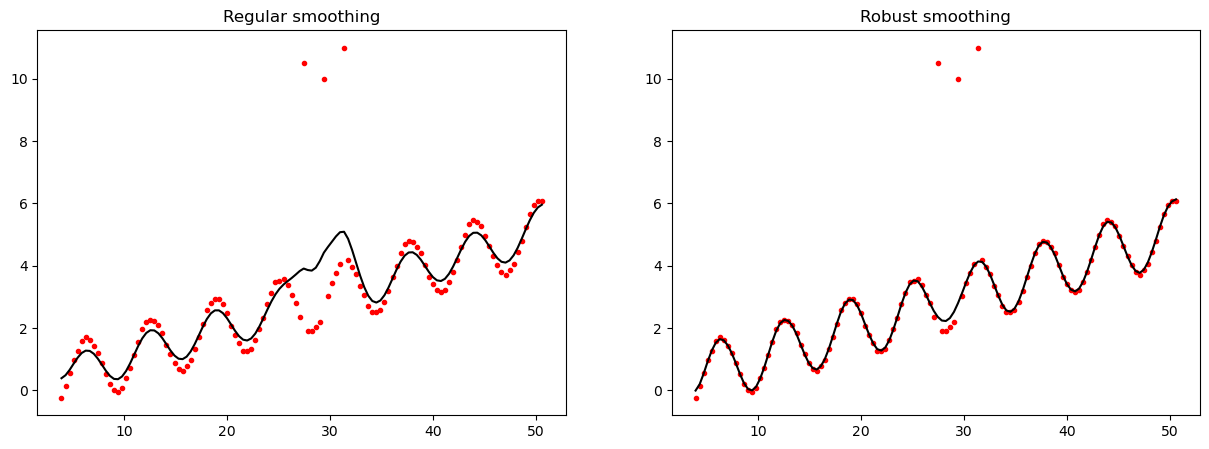

In [25]:
x = np.linspace(0, 100, 2**8)
y = np.cos(x) + 0.1 * x + np.random.rand(2**8)*0.1
y[[70, 75, 80]] = [10.5, 10, 11]
y = y[10:130]
x = x[10:130]
z_reg, s_reg, _, _ = smoothn(y.copy(), isrobust=False, debug_mode=False)  # Regular
z_rob, s_rob, _, _ = smoothn(y.copy(), isrobust=True, debug_mode=False)  # Robust

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(x, y, color='red', marker='.', linewidth=0)
axs[0].plot(x, z_reg, color='black')
axs[0].set_title("Regular smoothing")

axs[1].plot(x, y, color='red', marker='.', linewidth=0)
axs[1].plot(x, z_rob, color='black')
axs[1].set_title('Robust smoothing')
plt.show()


# Example 2
1d array robust curve smoothing (with outliers) and updated weights

<BarContainer object of 256 artists>

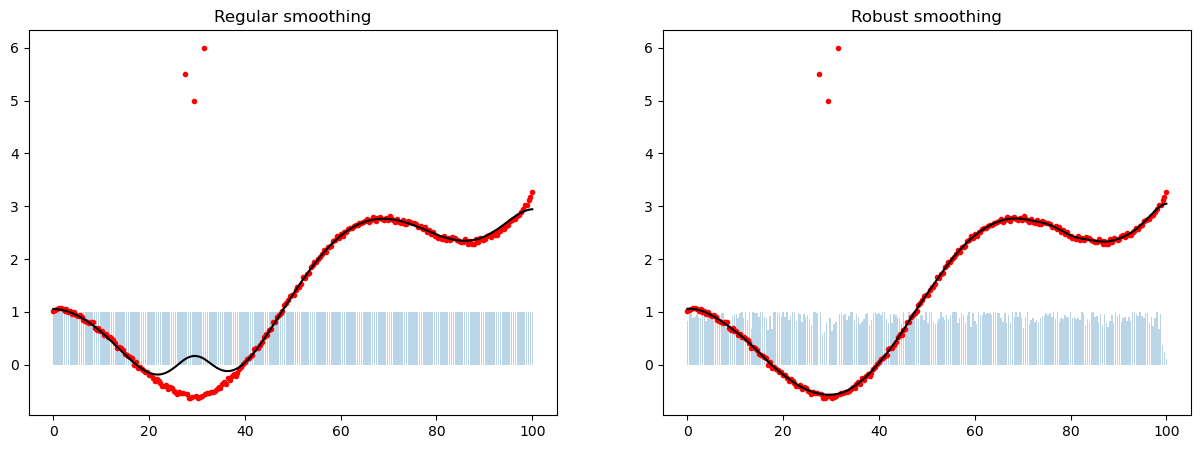

In [26]:
x = np.linspace(0, 100, 2 ** 8)
y = np.cos(x / 10) + (x / 50) ** 2 + np.random.rand(len(x)) / 10
y[[70, 75, 80]] = [5.5, 5, 6]

z_init_guess, dist = calc_init_guess(y, mask=np.isnan(y), coeff=0.1)
z_rob, s_rob, _, stats_rob = smoothn(
    y.copy(), isrobust=True, debug_mode=False, init_guess=z_init_guess,
    return_stats=('final_weights',))   # Robust
z_reg, s_reg, _, stats_reg = smoothn(
    y.copy(), isrobust=False, init_guess=z_init_guess,
    return_stats=('final_weights',))  # Regular

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(x, y, color='red', marker='.', linewidth=0)
axs[0].plot(x, z_reg, color='black')
axs[0].set_title("Regular smoothing")
axs[0].bar(x, stats_reg['final_weights'], alpha=0.3, width=0.3)

axs[1].plot(x, y, color='red', marker='.', linewidth=0)
axs[1].plot(x, z_rob, color='black')
axs[1].set_title('Robust smoothing')
axs[1].bar(x, stats_rob['final_weights'], alpha=0.3, width=0.3)

# Example 3
Smoothing a surface

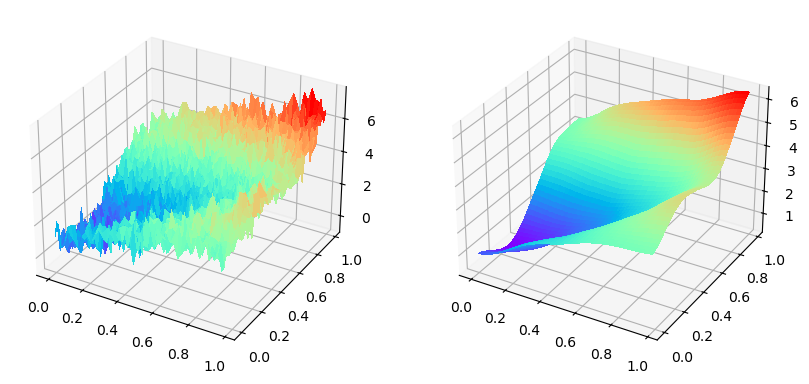

In [27]:
xp = np.arange(0, 1, 0.02)
[x,y] = np.meshgrid(xp, xp)
f = np.exp(x+y) + np.sin((x-2*y)*3)
fn = f + np.random.normal(size=f.size).reshape(f.shape) * 0.5
zr, smoothr, exit_flagr, statsr = smoothn(fn.copy())

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"},
                       figsize=(10,5))
axs[0].plot_surface(x, y, fn, cmap=plt.get_cmap('rainbow'),
                    linewidth=2, antialiased=False)
axs[1].plot_surface(x, y, zr, cmap=plt.get_cmap('rainbow'),
                    linewidth=2, antialiased=False)

# Example 4
Smooth 2d data with random and systematic gaps

Text(0.5, 1.0, 'Robust gapfilled')

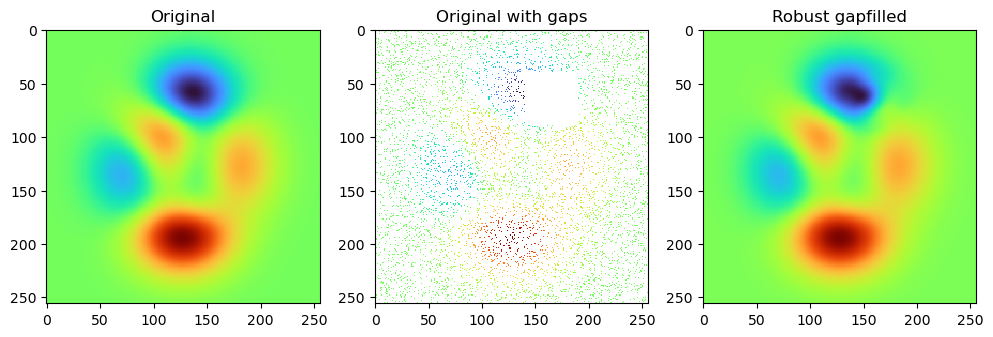

In [28]:
n = 256
mat = loadmat(os.path.join('assets', '2d_peaks_n256.mat'))
y_original = mat['y0']
assert y_original.shape == (n, n)
idx = np.random.permutation(n**2)
y = y_original.flatten()
y[idx[:int(len(idx)/ 1.1)]] = np.nan
y = y.reshape(n,n)
y[40:90, 140:190] = np.nan
z_init_guess, dist = calc_init_guess(y.copy(), mask=np.isnan(y), coeff=0.1)
zr, smoothr, exitflagsr, statsr = smoothn(
    y.copy(), isrobust=True, gap_value=np.nan,
    init_guess=z_init_guess, debug_mode=False)   # Robust smoothing

z_init_guess_matlab = loadmat(os.path.join('assets', 'matlab_initguess.mat'))['z'][0][0]
zr_matlab, smoothr, exitflagsr, statsr = smoothn(
    y.copy(), isrobust=True, init_guess=z_init_guess_matlab,
    debug_mode=False)   # Robust smoothing

cmap = plt.get_cmap("turbo")
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs[0].imshow(y_original, interpolation='none', cmap=cmap)
axs[0].set_title('Original')

axs[1].imshow(y, interpolation='none', cmap=cmap)
axs[1].set_title('Original with gaps')

axs[2].imshow(zr, interpolation='none', cmap=cmap)
axs[2].set_title('Robust gapfilled')


# Example 5
Smoothing 3d array (volumetric) data

Text(0.5, 0.92, 'After smoothing')

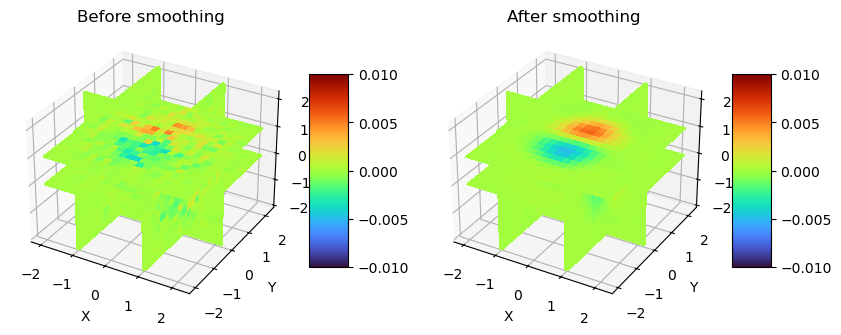

In [29]:
def plot_slices(x, y, z, data, xslices, yslices, zslices, ax, clim=(0,1)):
    data_n = data
    data_x = data_n[xslices,:,:]
    data_y = data_n[:,yslices,:]
    data_z = data_n[:,:,zslices]
    # Pick color map
    cmap = plt.get_cmap("turbo")
    norm = colors.Normalize(vmin=clim[0], vmax=clim[1])
    # Plot X slice
    data = {'x': [], 'y': [], 'z': []}
    for i, xslice in enumerate(xslices):
        d = data_x[i,:,:]
        data['x'].append(d)
        _ = ax.plot_surface(xslice, y[:, np.newaxis], z[np.newaxis, :],
                            rstride=1, cstride=1,
                            facecolors=cmap(norm(d)),
                            linewidth=3, antialiased=False,
                            shade=False)
    # Plot Y slice
    for i, yslice in enumerate(yslices):
        d = data_y[:,i,:]
        data['y'].append(d)
        _ = ax.plot_surface(x[:, np.newaxis], yslice, z[np.newaxis, :],
                            rstride=1, cstride=1,
                            facecolors=cmap(norm(d)),
                            linewidth=1, antialiased=False,
                            shade=False)
    # Plot Z slice
    for i, zslice in enumerate(zslices):
        d = data_z[:,:,i]
        data['z'].append(d)
        _ = ax.plot_surface(x[:, np.newaxis], y[np.newaxis, :],
                            np.atleast_2d(zslice),
                            rstride=1, cstride=1,
                            facecolors=cmap(norm(d)),
                            linewidth=1, antialiased=False,
                            shade=False)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    sl = cm.ScalarMappable(cmap=cmap, norm=norm)
    sl.set_array([])

    return sl, data


x = np.linspace(-2, 2.2, 21)
y = np.linspace(-2, 2.2, 19)
z = np.linspace(-2, 2.2, 17)
_x, _y, _z = np.meshgrid(y,x,z)
vn = _x * np.exp(-_x**2-_y**2-_z**2) + \
     (np.reshape(np.random.normal(size=_x.shape) * 0.01, _x.shape))

offset = np.outer(np.outer(slide(stop=1.1), slide(stop=1.0)),
                  slide(stop=0.9)).reshape(21,19,17)
vn *= offset

clim = (-0.01, 0.01)
xslices = np.array([-1, 1])
yslices = np.array([0])
zslices = np.array([0, 1])

fig, axs = plt.subplots(1, 2, figsize=(10,5), subplot_kw=dict(projection='3d'))
im, data = plot_slices(x, y, z, vn,
            xslices, yslices, zslices,
            axs[0], clim=clim)
fig.colorbar(im, shrink=0.5, aspect=5, ax=axs[0])
axs[0].set_title('Before smoothing')

v, smooth, flags, stats = smoothn(vn.copy(), isrobust=True)
im, data = plot_slices(x, y, z, v,
            xslices, yslices, zslices,
            axs[1], clim=(-0.01, 0.01))
fig.colorbar(im, shrink=0.5, aspect=5, ax=axs[1])
axs[1].set_title('After smoothing')

# Example 6
Smoothing a cardioid

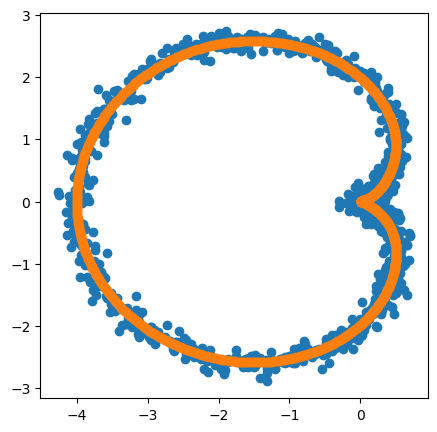

In [30]:
t = np.linspace(0, 2*np.pi, 1000)
x = 2*np.cos(t)*(1-np.cos(t)) + np.random.normal(size=t.size).reshape(t.shape)*0.1
y = 2*np.sin(t)*(1-np.cos(t)) + np.random.normal(size=t.size).reshape(t.shape)*0.1
x[123], y[524] = -9999, -9999 # add a few fill values to test if they are ignored correctly
z, smooth, flags, stats = smoothn(np.array([x, y]).copy(), axis=(1,))
x[123], y[524] = np.nan, np.nan
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.scatter(x, y)
ax.scatter(*z)


# Example 7
Smoothing a 3d parametric curve

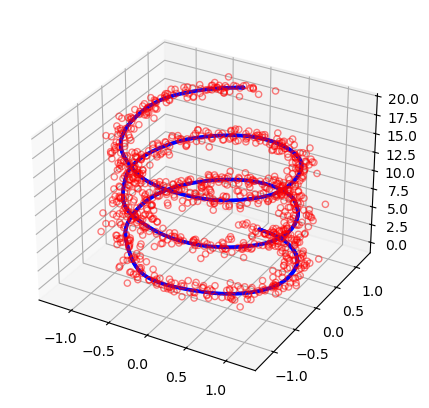

In [31]:
t = np.linspace(0, 6*np.pi, 1000)
x = np.sin(t) + np.random.normal(size=t.size).reshape(t.shape)*0.1
y = np.cos(t) + np.random.normal(size=t.size).reshape(t.shape)*0.1
z = t +  np.random.normal(size=t.size).reshape(t.shape)*0.1
u, smooth, flags, stats = smoothn(np.array([x,y,z]).copy(), axis=(1,))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(x,y,z, facecolors='none', edgecolors='red', alpha=0.5)
ax.scatter(*u, facecolors='blue', edgecolors='blue', alpha=1, s=3)

# Example 8
Smoothing a 2d vector field

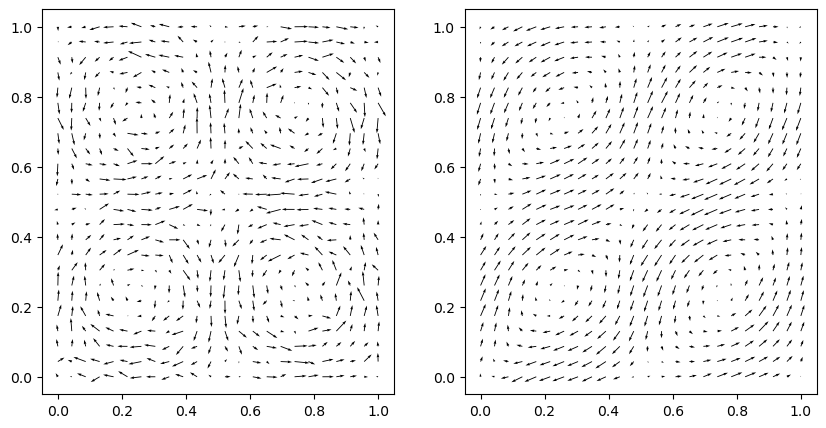

In [32]:
t = np.linspace(0, 1, 24)
[x,y] = np.meshgrid(t,t)
Vx = np.cos(2*np.pi*x+np.pi/2)*np.cos(2*np.pi*y)
Vy = np.sin(2*np.pi*x+np.pi/2)*np.sin(2*np.pi*y)
# Add Noise
Vx = Vx + np.sqrt(0.05)*np.random.normal(size=x.size).reshape(x.shape)
Vy = Vy + np.sqrt(0.05)*np.random.normal(size=x.size).reshape(x.shape)
I = np.random.permutation(Vx.size)
# Add Outliers
Vx.flatten()[I[:30]] = (np.random.normal(size=30)-0.5) * 5
Vx = Vx.reshape(Vy.shape)
Vy.flatten()[I[:30]] = (np.random.normal(size=30)-0.5) * 5
Vy = Vy.reshape(Vx.shape)
# Missing values
Vy.flatten()[I[30:60]] = np.nan
Vy = Vy.reshape(Vx.shape)
Vx.flatten()[I[30:60]] = np.nan
Vx = Vx.reshape(Vy.shape)
Vs, smooth, flags, stats = smoothn(np.array([Vx, Vy]).copy(), isrobust=True)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].quiver(x, y, Vx, Vy)
axs[1].quiver(x, y, *Vs)